In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
def ff(x, omega,alpha):
    # return omega
    # If you just return ff=omega, this gives the usual Classifier free guidance, the same as the one
    # called 'linear' in the calc_score function
    # return omega/(x**.75+1.e-6)

    return omega/(x**(-alpha)+1.e-6)


def calc_score(itau, dt, itfms, omega, q, alpha):
    expt = np.exp(-dt*(itfms-itau))
    linear = expt*(1+omega-omega*np.tanh(q*expt))
    nonlinear = expt*(1+(1 - np.tanh(q*expt)) *
                      ff(expt*(1-np.tanh(q*expt)), omega, alpha))
    normdiff = expt*(1-np.tanh(q*expt))  # Norm of S_full-S_class
    return nonlinear, normdiff


def init_backward():
    return np.random.normal(0, 1)


def calc_traj_back_exact(qinit, nt, dt, itfms, omega, alpha):
    qback = np.zeros(nt)
    time = np.zeros(nt)
    normd = np.zeros(nt)
    qback[0] = qinit
    q = qback[0]
    time[0] = 0
    for it in np.arange(nt-1):
        eta = np.random.normal(0, np.sqrt(2*dt))
        # rx=xback[it,:]
        sc, normdiff = calc_score(it, dt, itfms, omega, q, alpha)
        q = (1-dt)*q+2*dt*sc+eta
        qback[it+1] = q
        time[it+1] = it*dt
        normd[it] = normdiff
    return time, qback,normd

In [3]:
#Here we run three single trajectories just to have a look
qinit=init_backward()
dt=.01 # K: timesteps
nt=800 #final time is nt*dt
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
alpha = -0.75
itfms=nt-ns
print('iterations nt=',nt,'time step dt=',dt,'speciation ns=',ns)
omega=0
time,qtraj0,normdiff0=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)
omega=2
time,qtraj1,normdiff1=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)
omega=4
time,qtraj2,normdiff2=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)

iterations nt= 800 time step dt= 0.01 speciation ns= 200


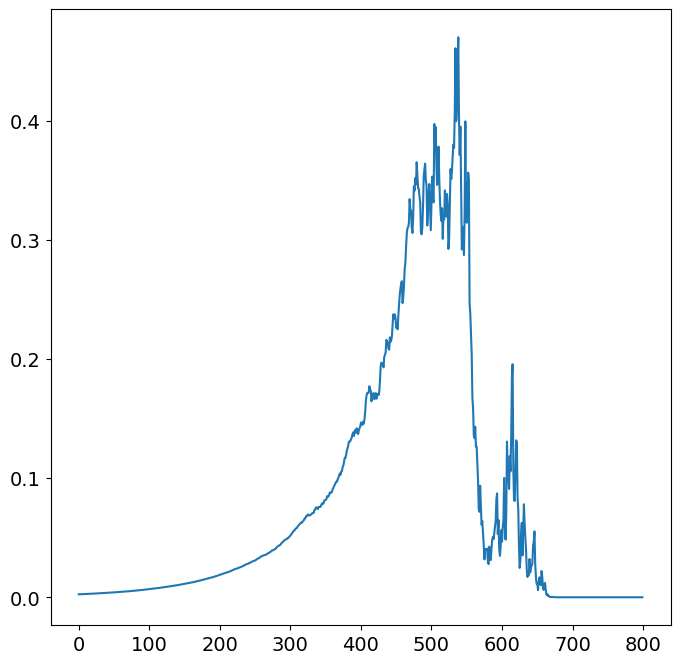

In [4]:
# time goes from 0 to 8
# paths all end up in mu=1
plt.plot(normdiff0)

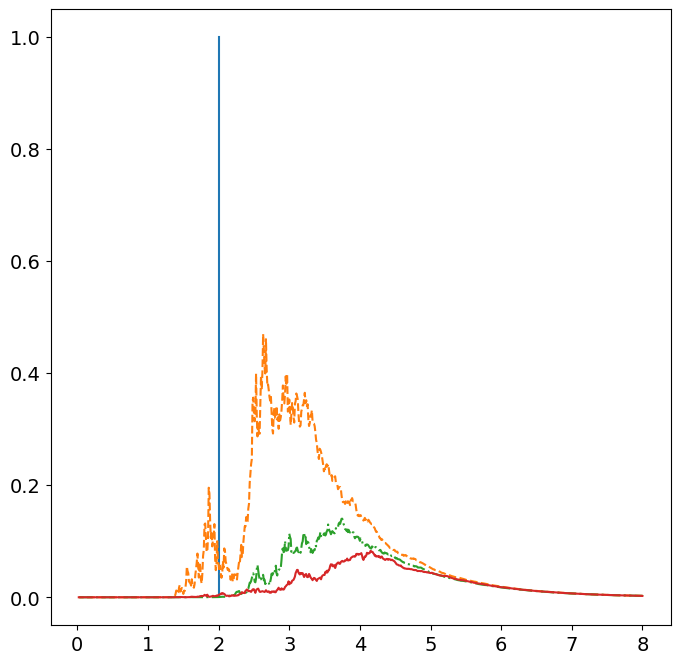

In [5]:
#plt.plot(nt*dt-time,qtraj0)
#plt.plot(nt*dt-time,qtraj1)
#plt.plot(nt*dt-time,qtraj4)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,1])
plt.plot(nt*dt-time,normdiff0,'--')
plt.plot(nt*dt-time,normdiff1,'-.')
plt.plot(nt*dt-time,normdiff2)
#plt.axis([0,6,0,.5])

In [6]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
ns=400 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns

alpha=-0.75

nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in np.arange(nsample):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)

In [8]:
qtraj[0,:,-1]

array([54.61162508, 54.09218905, 55.39170676, 54.02061681, 55.75606788,
       53.47473744, 54.36711215, 52.79997229, 54.59387739, 54.53951263,
       54.32946475, 53.68547666, 54.82375403, 53.64507969, 53.7071873 ,
       54.27694638, 55.03885853, 53.00984155, 54.62803751, 52.87606667,
       53.47643504, 53.23388497, 54.07771003, 54.11023138, 53.13927405,
       54.37063902, 54.28564405, 55.17367021, 51.58511146, 54.2218182 ,
       53.21510529, 54.25679087, 54.35982536, 53.81793202, 53.89764543,
       55.05098073, 53.07335078, 53.57098627, 52.66088965, 55.70572202,
       55.58936643, 56.25234669, 56.0556885 , 52.83137762, 51.85655342,
       52.95426568, 53.94902153, 52.70200349, 54.38922335, 53.09514331,
       53.69817349, 53.96975965, 52.138943  , 54.29076086, 54.59848536,
       54.36543119, 54.40861317, 54.85294022, 52.85492228, 54.55376027,
       53.19556114, 52.31324911, 55.32585939, 54.19332845, 52.54168005,
       54.12076964, 53.62954831, 53.94579281, 53.59789413, 53.90

0it [00:00, ?it/s]

4it [00:21,  5.27s/it]/tmp/ipykernel_1301124/1133115854.py:7: RuntimeWarning: divide by zero encountered in scalar power
  return omega/(x**(-alpha)+1.e-6)
7it [00:37,  5.40s/it]


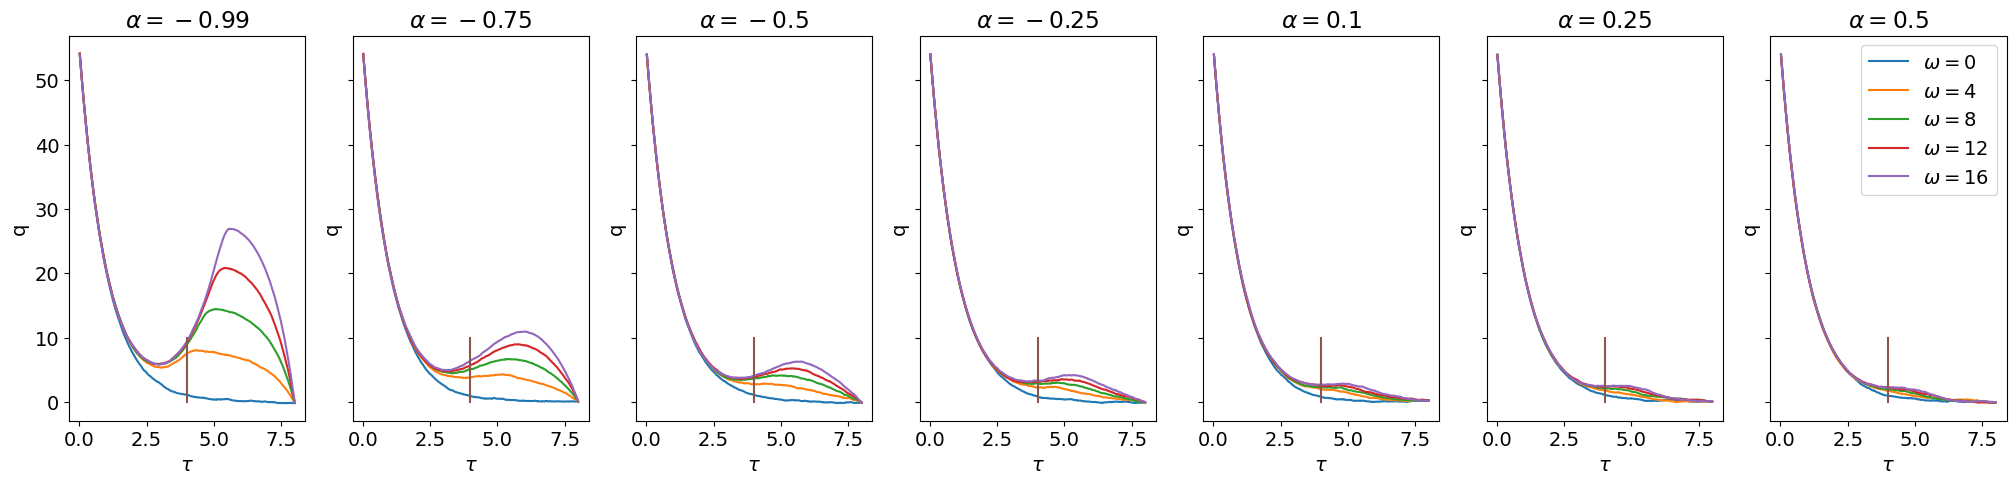

In [56]:
from tqdm import tqdm
alphas = [-0.99, -0.75, -0.5, -0.25, 0.1, 0.25, 0.5]
fig, ax = plt.subplots(1, len(alphas), sharex=True, sharey=True)
fig.set_size_inches(25, 5)
for i, alpha in tqdm(enumerate(alphas)):
    nomega=5
    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)
    
    
    for iomega in np.arange(nomega):
        qav = np.mean(qtraj, axis=1)
        ax[i].plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
    ax[i].plot([nt*dt-dt*itfms, nt*dt-dt*itfms], [0,10])
    ax[i].set_xlabel(r'$\tau$')
    ax[i].set_ylabel('q')
    #ax[iomega].text(7,8,'$\omega=0$ to $16$')
    # ax[iomega].axis([0,12,-1,15])
    #ax[iomega].savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
    ax[i].set_title(f'$\\alpha={alpha}$')
plt.legend()
plt.show()

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


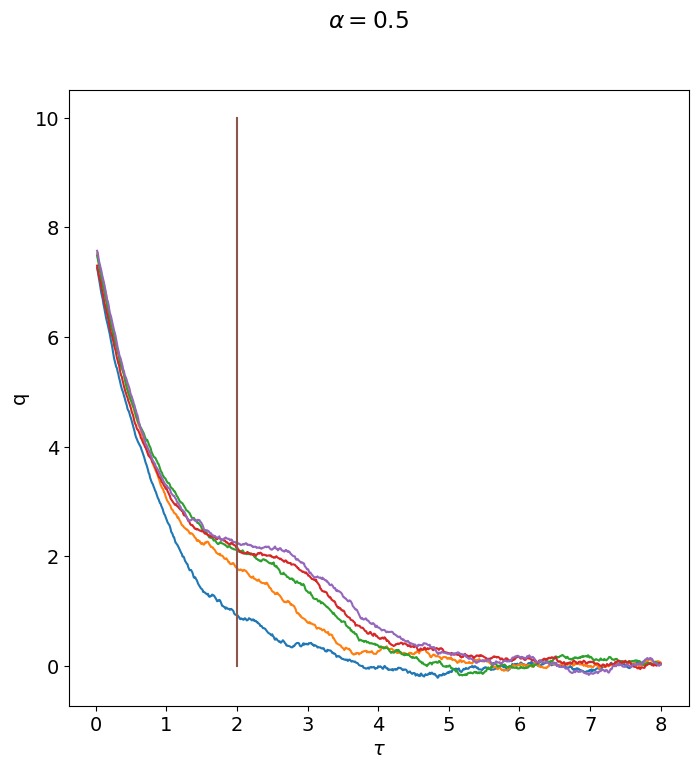

In [26]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    qav=np.mean(qtraj,axis=1)
    plt.plot(nt*dt-time,qav[iomega,:])
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,10])
plt.xlabel(r'$\tau$')
plt.ylabel('q')
#plt.text(7,8,'$\omega=0$ to $16$')
# plt.axis([0,12,-1,15])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.suptitle(f'$\\alpha={alpha}$')
plt.show()

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


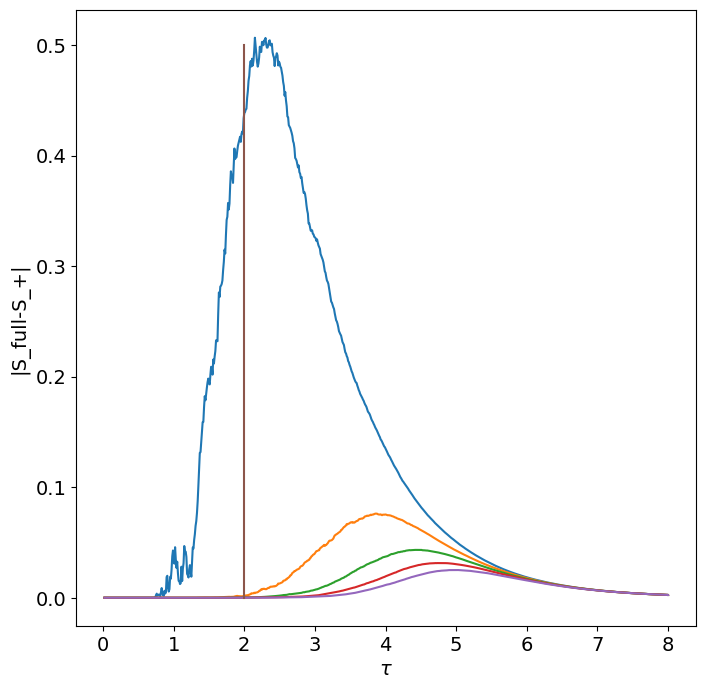

In [16]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    normav=np.mean(normstat,axis=1)
    plt.plot(nt*dt-time,normav[iomega,:])
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,.5])
plt.xlabel(r'$\tau$')
plt.ylabel('|S_full-S_+|')
#plt.text(7,8,'$\omega=0$ to $16$')
#plt.axis([0,12,-1,10])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.show()

# kruno new

In [38]:
def ff(x, omega,alpha):
    # return omega
    # If you just return ff=omega, this gives the usual Classifier free guidance, the same as the one
    # called 'linear' in the calc_score function
    # return omega/(x**.75+1.e-6)

    return omega/(x**(-alpha)+1.e-6)


def calc_score_k(itau, dt, itfms, omega, q, alpha):
    expt = np.exp(-dt*(itfms-itau))
    linear = expt*(1+omega-omega*np.tanh(q*expt))
    nonlinear = expt*(1+(1 - np.tanh(q*expt)) *
                      ff(expt*(1-np.tanh(q*expt)), omega, alpha))
    normdiff = expt*(1-np.tanh(q*expt))  # Norm of S_full-S_class
    return nonlinear, normdiff

def calc_new_score_k(itau, dt, itfms, omega, q, alpha):
    expt = np.exp(-dt*(itfms-itau))
    linear = expt*(1+omega-omega*np.tanh(q*expt))
    # nonlinear = expt*(1+(1 - np.tanh(q*expt)) *
                    #   ff(expt*(1-np.tanh(q*expt)), omega, alpha))
    normdiff = expt*(1-np.tanh(q*expt))  # Norm of S_full-S_class
    return linear, normdiff



def init_backward():
    return np.random.normal(0, 1)


def calc_traj_back_exact_k(qinit, nt, dt, itfms, omega, alpha):
    qback = np.zeros(nt)
    time = np.zeros(nt)
    normd = np.zeros(nt)
    qback[0] = qinit
    q = qback[0]
    time[0] = 0
    for it in np.arange(nt-1):
        eta = np.random.normal(0, np.sqrt(2*dt))
        # rx=xback[it,:]
        if it<itfms:
            sc, normdiff = calc_score_k(it, dt, itfms, omega, q, alpha)
        else:
            sc, normdiff = calc_new_score_k(it, dt, itfms, 0., q, alpha)
        q = (1-dt)*q+2*dt*sc+eta
        qback[it+1] = q
        time[it+1] = it*dt
        normd[it] = normdiff
    return time, qback,normd

In [32]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns

0it [00:00, ?it/s]

4it [00:20,  5.20s/it]/tmp/ipykernel_1301124/1133115854.py:7: RuntimeWarning: divide by zero encountered in scalar power
  return omega/(x**(-alpha)+1.e-6)
7it [00:36,  5.29s/it]


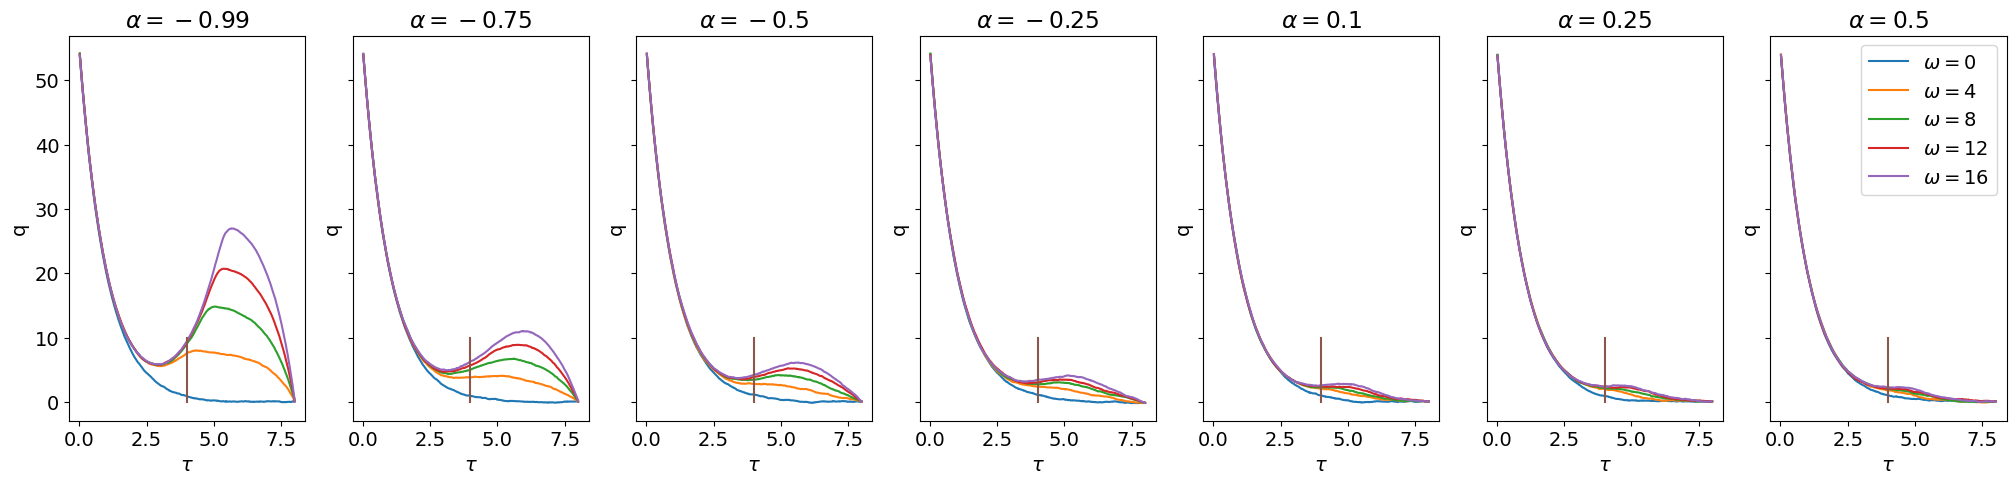

In [57]:
from tqdm import tqdm
alphas = [-0.99, -0.75, -0.5, -0.25, 0.1, 0.25, 0.5]
fig, ax = plt.subplots(1, len(alphas), sharex=True, sharey=True)
fig.set_size_inches(25, 5)
for i, alpha in tqdm(enumerate(alphas)):
    nomega=5
    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)
    
    
    for iomega in np.arange(nomega):
        qav = np.mean(qtraj, axis=1)
        ax[i].plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
    ax[i].plot([nt*dt-dt*itfms, nt*dt-dt*itfms], [0,10])
    ax[i].set_xlabel(r'$\tau$')
    ax[i].set_ylabel('q')
    ax[i].set_title(f'$\\alpha={alpha}$')
plt.legend()
plt.show()

0it [00:00, ?it/s]

0it [00:01, ?it/s]


KeyboardInterrupt: 

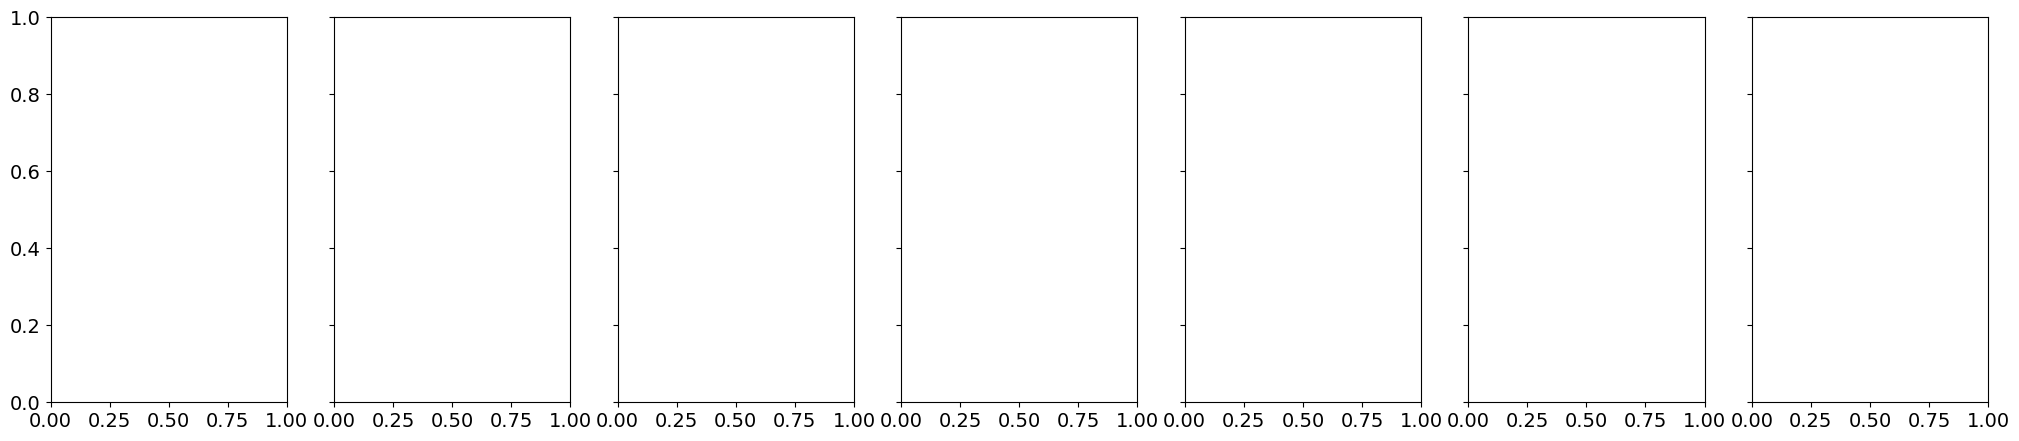

In [59]:
from tqdm import tqdm
alphas = [-0.99, -0.75, -0.5, -0.25, 0.1, 0.25, 0.5]
fig, ax = plt.subplots(1, len(alphas), sharex=True, sharey=True)
fig.set_size_inches(25, 5)
for i, alpha in tqdm(enumerate(alphas)):
    nomega=5
    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact_k(qinit,nt,dt,itfms,omega, alpha)
    
    
    for iomega in np.arange(nomega):
        qav = np.mean(qtraj, axis=1)
        ax[i].plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
    ax[i].plot([nt*dt-dt*itfms, nt*dt-dt*itfms], [0,10])
    ax[i].set_xlabel(r'$\tau$')
    ax[i].set_ylabel('q')
    ax[i].set_title(f'$\\alpha={alpha}$')
plt.legend()
plt.show()

# STD

7it [00:34,  4.95s/it]


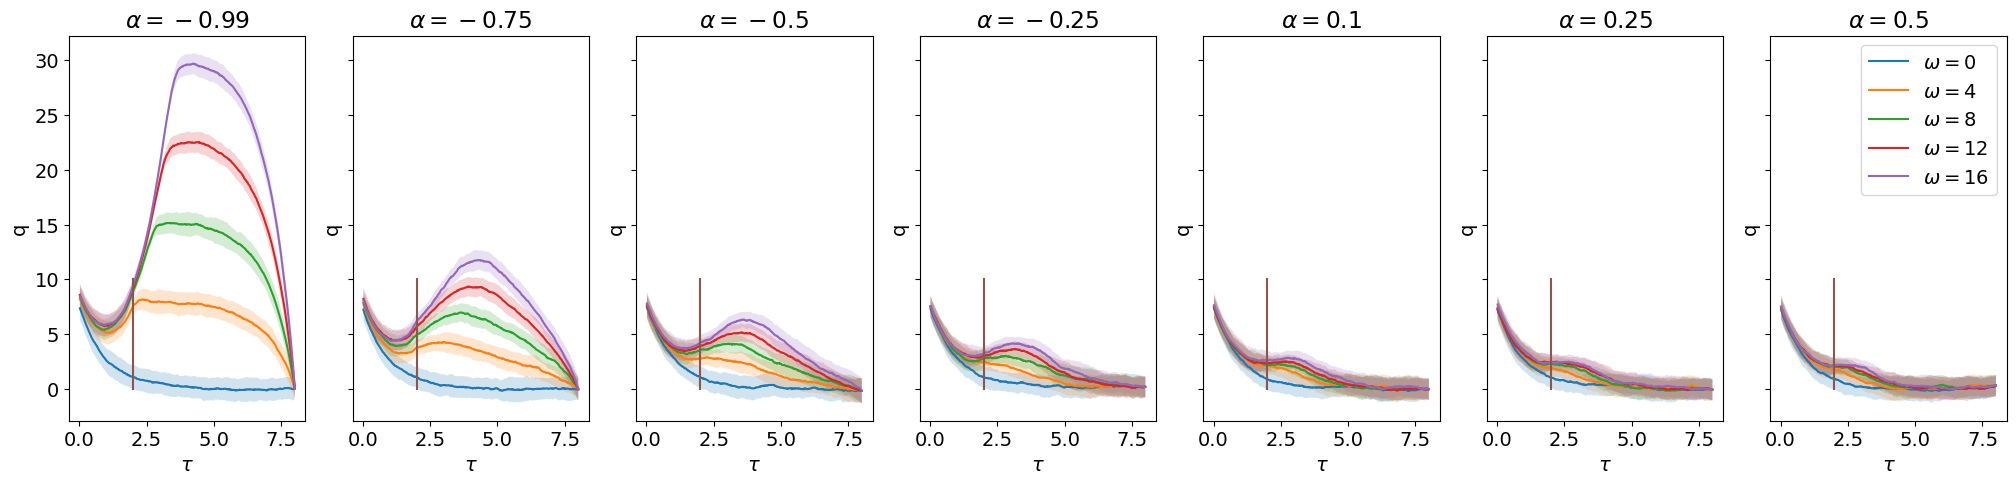

In [41]:

from tqdm import tqdm
alphas = [-0.99, -0.75, -0.5, -0.25, 0.1, 0.25, 0.5]
fig, ax = plt.subplots(1, len(alphas), sharex=True, sharey=True)
fig.set_size_inches(25, 5)
for i, alpha in tqdm(enumerate(alphas)):
    nomega=5
    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact_k(qinit,nt,dt,itfms,omega, alpha)
    
    
    for iomega in np.arange(nomega):
        qav = np.mean(qtraj, axis=1)
        qstd = np.std(qtraj, axis=1)
        ax[i].plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
        ax[i].fill_between(nt*dt-time, qav[iomega,:]-qstd[iomega,:], qav[iomega,:]+qstd[iomega,:], alpha=0.2)
    ax[i].plot([nt*dt-dt*itfms, nt*dt-dt*itfms], [0,10])
    ax[i].set_xlabel(r'$\tau$')
    ax[i].set_ylabel('q')
    ax[i].set_title(f'$\\alpha={alpha}$')
plt.legend()
plt.show()

In [ ]:

from tqdm import tqdm
alphas = [-0.99]
fig, ax = plt.subplots(1, len(alphas), sharex=True, sharey=True)
fig.set_size_inches(25, 5)
for i, alpha in tqdm(enumerate(alphas)):
    nomega=5
    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact_k(qinit,nt,dt,itfms,omega, alpha)
    
    
    for iomega in np.arange(nomega):
        qav = np.mean(qtraj, axis=1)
        qstd = np.std(qtraj, axis=1)
        print(qstd)
        print(asd)
        ax[i].plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
        ax[i].fill_between(nt*dt-time, qav[iomega,:]-qstd[iomega,:], qav[iomega,:]+qstd[iomega,:], alpha=0.2)
    ax[i].plot([nt*dt-dt*itfms, nt*dt-dt*itfms], [0,10])
    ax[i].set_xlabel(r'$\tau$')
    ax[i].set_ylabel('q')
    ax[i].set_title(f'$\\alpha={alpha}$')
plt.legend()
plt.show()

In [50]:
print(qav[:,-1])
print(qstd[:,-1])

[7.21577711 8.18356929 8.40209617 8.53268039 8.44845635]
[1.07448819 1.04155725 1.01890873 1.01986309 0.91598198]


In [51]:
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in np.arange(nsample):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega, alpha)


qav = np.mean(qtraj, axis=1)
qstd = np.std(qtraj, axis=1)


In [54]:
print(qav[:,-1])
print(qstd[:,-1])
print(4*np.arange(nomega))

[7.36343192 8.23450893 8.58786206 8.55114805 8.52084792]
[1.04272857 0.98882851 0.94409738 1.06638268 0.97536508]
[ 0  4  8 12 16]
